# Import libraries

In [1]:
import sys
import os
sys.path.append('Devices/Taiko/')
import time
import numpy as np
from snAPI.Main import *
import TaikoON_OFF as tk
import Motor_f as mot
import matplotlib.pyplot as plt

# Functions

In [2]:
def Focusing(handlez,sn,z0,z1,step,wait):
    sn.timeTrace.measure(100000, False, False)
    count_arr=np.array([])
    z_arr=np.arange(z0,z1,step)
    for zi in z_arr:
        mot.move_abs_z(zdrive,zi)
        sn.timeTrace.clearMeasure()
        time.sleep(wait)
        counts, _ = sn.timeTrace.getData() 
        count_arr=np.append(count_arr,np.sum(counts[ch]))
    sn.timeTrace.stopMeasure()
    return count_arr,z_arr  

In [3]:
def XY_scan(handlex,handley,x0,xf,Nx,y0,yf,Ny,wait,folder):# positions in micrometers
    #Create the scanning pattern (it is important to be ordered to minimize displacements)
    xs=np.linspace(x0,xf,Nx)
    ys=np.linspace(y0,yf,Ny)
    XY=np.meshgrid(xs,ys)
    Order=np.zeros_like(XY[0])
    for i in range(0,np.shape(XY[0])[0]):
        for j in range(0,np.shape(XY[0])[1]):
            if j%2==0:
                Order[i,j]=i+Ny*j
            else:
                Order[i,j]=Nx-i-1+Ny*j
    xx,yy,o=XY[0].flatten(),XY[1].flatten(),Order.flatten()
    xsorted=[x for _, x in sorted(zip(o,xx))]
    ysorted=[x for _, x in sorted(zip(o, yy))]
    pairs=np.vstack((xsorted,ysorted)).T
    # The points of the scan are saved at pairs (ordered)
    for point in pairs:
        mot.move_abs_xy(handlex,point[0]) #move functions work in micrometers
        mot.move_abs_xy(handley,point[1])
        time.sleep(wait)
        sn.setPTUFilePath("./Data/{}/PTU_{:.2f}_{:.2f}.ptu".format(folder,point[0],point[1]))
        sn.histogram.measure(1000,savePTU=True)
    return True

In [18]:
def Lifetime(sn,texp):
    sn.histogram.measure(texp*1000, True, False)
    data, bins = sn.histogram.getData()
    return data,bins  

In [33]:
def GetCountRate(sn,ch,texp):
    sn.initDevice(MeasMode.T2)
    sn.timeTrace.measure(texp*1000, True, False)
    data, bins = sn.timeTrace.getData()
    return np.mean(data[ch])

# Connections

## Connect motors

### Piezos (for scanning)

In [5]:
xdrive=mot.connectX()
ydrive=mot.connectY()

---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01403418
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 10
---- Connecting PDXC motor ----
Devices=[['01403418', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM11&COM'], ['01404934', '0403&6015&THORLABS PDXC 1.51&THORLABS&COM10&COM']]
connect  01404934
Found PDX1 stage
-- Stage settings --
-  closed loop mode  -
set loop to closed loop
-  Manual Mode  -
set trigger mode to manual mode
set PositionCalibration home
get CalibrationIsCompleted: done
set TargetSpeed to 10


### Z axis (For focusing)

In [6]:
zdrive=mot.connectZ()

Found Device 1 SN: 61516 (T-NA08A25) -> Connection 1 (Binary Serial port: COM5) devices
-Homed-


## Connect HydraHarp

In [7]:
sn = snAPI(libType=LibType.HH)
sn.getDeviceIDs()
print('Available devices are:'+str(sn.deviceIDs))

Available devices are:['', '', '', '1039212', '', '', '', '']


In [38]:
sn.getDevice('1039212')
sn.initDevice(MeasMode.T3)
sn.loadIniConfig("config\HH.ini")
sn.device.setBinning(8)

1

In [39]:
sn.getDeviceConfig()
print(sn.deviceConfig)

{'DeviceType': 0, 'FileDevicePath': '', 'ID': '1039212', 'Index': 3, 'Model': 'HydraHarp 400', 'PartNo': '930021', 'Version': '2.0', 'BaseResolution': 1.0, 'Resolution': 256.0, 'BinSteps': 26, 'NumChans': 4, 'NumMods': 4, 'SyncDivider': 1, 'SyncTrigMode': 'CFD', 'SyncDiscrLvl': 50, 'SyncZeroxLvL': 0, 'SyncChannelOffset': -10000, 'SyncChannelEnable': 1, 'SyncDeadTime': 0, 'HystCode': 0, 'TimingMode': 0, 'StopCount': 4294967295, 'Binning': 8, 'Offset': 0, 'LengthCode': 6, 'NumBins': 32768, 'MeasCtrl': 0, 'StartEdge': 0, 'StopEdge': 0, 'TriggerOutput': 0, 'MarkerHoldoffTime': 0, 'HoldTime': 2, 'OflCompression': 2, 'MarkerEdges': [0, 0, 0, 0], 'MarkerEna': [0, 0, 0, 0], 'ModsCfg': [{'Index': 0, 'ModelCode': 1000, 'VersionCode': 51052545}, {'Index': 1, 'ModelCode': 1010, 'VersionCode': 33554954}, {'Index': 2, 'ModelCode': 1040, 'VersionCode': 18219530}, {'Index': 3, 'ModelCode': 1040, 'VersionCode': 18219530}], 'ChansCfg': [{'Index': 0, 'TrigMode': 'CFD', 'DiscrLvl': 50, 'ZeroXLvl': 0, 'Cha

In [10]:
sn.deviceConfig['Resolution']

256.0

## Connect Taiko laser

In [11]:
laser_id=tk.ON(reprate=1e6,perc=500)

  [ Python ]                               Library version: 2.1.64.4505

  USB-Driver Service: 'WINUSB'; V1.0.0.3, 20.07.2023

  USB-Index 0: PDL-M1 with serial number 1047648 found (ready to run)
  USB-Index 0: PDL-M1 opened.

  - FW   : 2.1.4513
  - FPGA : 2.3
  - LH   : 1.0

  Laser is NOT locked by On/Off Button
  Laser is NOT locked by key

  Connected laser head:
  - laser head type       : LDH-IB-375-B
  - date of manufacturing : 23-02-13
  - laser power class     : 3B
  - frequency range       :   1  Hz -  80 MHz

  Frequency currently set :   1 MHz
  Frequency now set to    :   1 MHz
  Pulse power set to      :  50.0 %  ==>  34.971 μW

  Got via TagList:
  -                  Frequency :   1 MHz
  -                  TempScale :   0  ==>  °C
  -                 TargetTemp :  37.0 °C
  -               TriggerLevel :   0.000 V
  -        LDH_PulsePowerTable :   0  ==> linear power mode
  -        TriggerLevelHiLimit :   1.065  W
  -         PulsePowerPermille : 500 permille  ==>  

In [21]:
#tk.setRepRate(laser_id,1e6)
#tk.setPermille(laser_id,50)

  Frequency now set to    :   1 MHz
  Frequency now set to    : 50  permille


In [17]:
#tk.OFF(laser_id)

# Measurements

## Select position

In [12]:
x0=0 ## positions are in micrometers
y0=0
mot.move_abs_xy(xdrive,x0)
mot.move_abs_xy(ydrive,y0)

## Focusing

In [13]:
ch=3

In [14]:
counts,zs=Focusing(zdrive,sn,2800,5000,10,0.1)

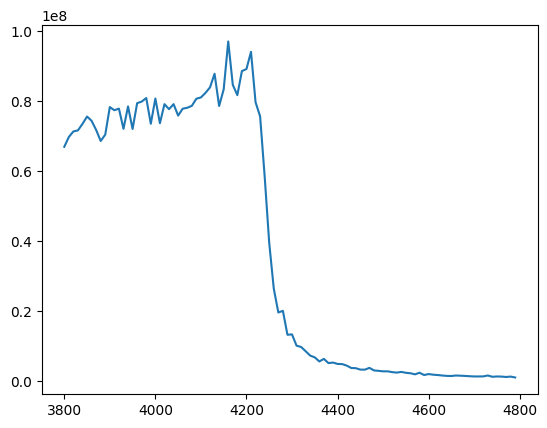

In [16]:
plt.plot(zs[100:200],counts[100:200])

In [17]:
mot.move_abs_z(zdrive,4200)

## Check count rates

In [37]:
tk.setPermille(laser_id,5)
sync_cr=GetCountRate(sn,0,1)
ch_cr=GetCountRate(sn,3,1)
tk.setPermille(laser_id,0)
print('Sync count rate: {}'.format(sync_cr))
print('Channel count rate: {}'.format(ch_cr))
print('Pulses per sync (%): {}'.format(ch_cr/sync_cr*100))

  Frequency now set to    : 5  permille
  Frequency now set to    : 0 Gpermille
Sync count rate: 99914.1
Channel count rate: 30816.7
Pulses per sync (%): 30.843194303907058


## Lifetime measurement

In [29]:
tk.setPermille(laser_id,5)
print('Measuring')
data,bins=Lifetime(sn,1)
tk.setPermille(laser_id,0)

  Frequency now set to    : 5  permille
Measuring
  Frequency now set to    : 0 Gpermille


(0.0, 1000000.0)

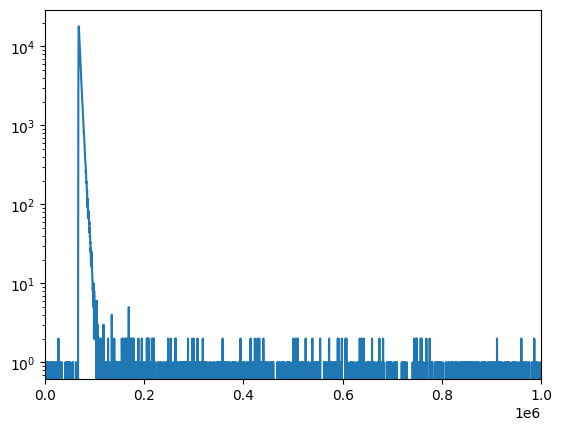

In [30]:
plt.plot(bins,data[3])
plt.yscale('log')
plt.xlim([0,1e6])

## Scanning

In [ ]:
xran=100
yran=100
nx=50
ny=50
texp=0.1
tk.setPermille(laser_id,5)
XY_scan(xdrive,ydrive,x0-xran/2,x0+xran/2,nx,y0-yran/2,y0+yran/2,ny,texp,'Trial2')
tk.setPermille(laser_id,0)

  Frequency now set to    : 5  permille
